# MLP + LoRA 구현하기

Author : 정상근 (hugmanskj@gmail.com)

> 알림>
> 교육용 목적으로 제작된 코드입니다.

이 노트북에서는 MNIST 숫자 데이터를 MLP 에 기반한 아주 간단한 네트워크를 이용해서 훈련 및 테스트 해보고, 다시 해당 네트워크를 LoRA테크닉을 이용해서 훈련파라미터를 줄이는 방법을 보입니다.

아래의 소프트웨어와 프레임워크를 사용해서 진행하겠습니다.

In [1]:
!pip install -q lightning==2.1.1
!pip install -q seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 896.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from IPython.display import Markdown, display

In [3]:
import os

import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms

from torchvision.datasets import MNIST

In [4]:
## Lookup or Register dataset folder
PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")

## If your GPU has not enough memory, reduce the size manually!
BATCH_SIZE = 256 if torch.cuda.is_available() else 64

In [5]:
def bytes_to_gb(bytes):
    """Convert bytes to gigabytes."""
    return bytes / 1e9

def bytes_to_mb(bytes):
    """Convert bytes to megabytes."""
    return bytes / 1e6

## MLP 기반 Orignal MNIST 용 네트워크 구성

여기서는 아주 단순한 Data 변형을 통해 MNIST 문제를 풀어냅니다.
1. Image → 784
2. Linear : 784 → 500
3. Linear : 500 → 500      <이 Layer가 LoRA대상이 됩니다>
4. Linear : 500 → 10

이 네트워크를 이용해 훈련 및 테스트를 진행 합니다.

In [6]:
# Model design with Lightning Module
class LitMNIST(L.LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, learning_rate=2e-4):
        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.dims = (1, 28, 28)
        channels, width, height = self.dims

        # to normalize dataset with 'standardization' technique
        # refer : https://www.wikiwand.com/en/Standard_score
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,),  # mean
                                     (0.3081,)), # standard deviation
            ]
        )

        # Define Original Model
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels * width * height, 500), # 784 -> 500
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, 500), # 500 -> 500  <-- this layer will be LoRA target
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, self.num_classes), # 500 -> 10
        )

        self.val_accuracy  = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_accuracy.update(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [7]:
# Data module for MNIST
class MNISTDataModule(L.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

    def prepare_data(self):
        # Download MNIST dataset
        MNIST(os.getcwd(), train=True, download=True, transform=self.transform)
        MNIST(os.getcwd(), train=False, download=True, transform=self.transform)

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        mnist_full = MNIST(os.getcwd(), train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset for use in dataloader(s)
        self.mnist_test = MNIST(os.getcwd(), train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size)


In [8]:
# To reproduce the same result
L.seed_everything(42)

# Initialize our data module
mnist_data = MNISTDataModule(batch_size=BATCH_SIZE)

# Model Design
model = LitMNIST()
model.to('cuda')

# Trainer Settings
trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=1,
    logger=CSVLogger(save_dir="logs/"),
)

# Train & Test
trainer.fit(model, mnist_data)
trainer.save_checkpoint("base_model.ckpt")
trainer.test(datamodule=mnist_data)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
100%|██████████| 9.91M/9.91M [00:03<00:00, 2.76MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.7MB/s]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=0-step=215.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_0/checkpoints/epoch=0-step=215.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_0/

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9319000244140625     │
│         test_loss         │    0.22807112336158752    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.22807112336158752, 'test_acc': 0.9319000244140625}]

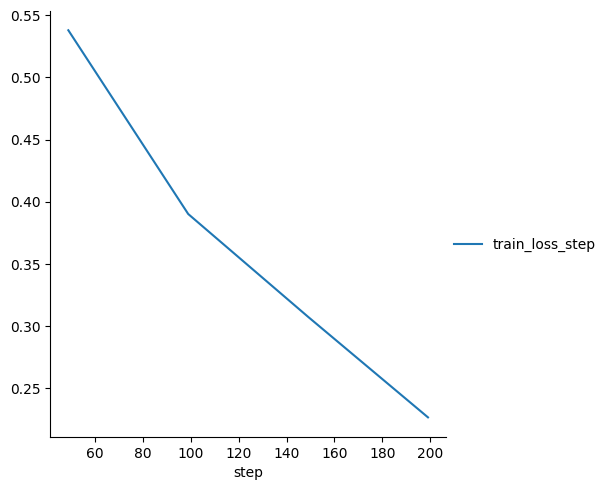

In [9]:
# ## ---- Display Log ---- ##
import pandas as pd
import seaborn as sn

df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
df.head()
v_df = df[['step', 'train_loss_step'] ]
v_df.set_index("step", inplace=True)
sn.relplot(data=v_df, kind="line")

In [10]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params:,} || all params: {all_param:,} || trainable : {100 * trainable_params / all_param}%"
    )
    return trainable_params

In [11]:
ori_p = print_trainable_parameters( model )

trainable params: 648,010 || all params: 648,010 || trainable : 100.0%


위에서 model parameter 의 수가 648,010 임을 확인하시기 바랍니다.

## LoRA 를 이용해서 Fine-Tuning 수행하기

이제 LoRA를 적용해보겠습니다.
외부 Library (예를 들어 hugginface) 를 쓰지 않고 직접 LoRA를 구현해보겠습니다.

가장 먼저 어떤 Network 부분을 LoRA로 접근할 것인지를 결정해야 합니다.

본 실습에서는, 오리지널 Network 에서 500->500 에 해당하는 Linear Layer를 LoRA로 모델링 해보겠습니다.

In [12]:
# LoRA MLP for Fine-Tuning
class LoRALitMNIST(LitMNIST):
    def __init__(self, rank, base_model_ckpt, learning_rate=2e-4, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Load the pre-trained base model weights
        base_model = LitMNIST.load_from_checkpoint(base_model_ckpt)
        self.model = base_model.model
        print(self.model)
        print( self.model[4])

        # model = nn.Sequential(
        # [0]    nn.Flatten(),
        # [1]   nn.Linear(channels * width * height, 500), # 784 -> 500
        # [2]   nn.ReLU(),
        # [3]   nn.Dropout(0.1),
        # [4]   nn.Linear(500, 500), # 500 -> 500  <-- this layer will be LoRA target
        # [5]   nn.ReLU(),
        # [6]   nn.Dropout(0.1),
        # [7]   nn.Linear(500, self.num_classes), # 500 -> 10
        #)


        #self.W = self.model[4] # target layer selection

        # Freeze all the parameters of the base model
        for param in self.model.parameters():
            param.requires_grad = False

        # additional lora
        input_size = 500
        output_size = 500
        rank = 16

        self.W_A = nn.Parameter(torch.randn(input_size, rank))
        self.W_B = nn.Parameter(torch.randn(rank, output_size))
        self.alpha  = 1.0

        # Initialization of LoRA weights
        nn.init.normal_(self.W_A, mean=0.0, std=1.0) # N(0, std) at first
        nn.init.zeros_(self.W_B) # zero at first


    # Correctly override the forward method
    def forward(self, x):
        x = self.model[0](x)  # flatten
        x = self.model[1](x)  # 784 -> 500
        x = self.model[2](x)  # RELU
        x = self.model[3](x)  # Dropout

        # lora ------------------------------
        # regular forward
        #h = x @ self.W   <-- we defined self.W as linear layer
        h = self.model[4](x) # h = x @ self.W  (same code)

        # LoRA forward (delta W)
        h_prime = x @ ( self.W_A @ self.W_B ) # [B, 500] x ([500,r]x[r,500]=[500,500])

        # scaled
        h = h + h_prime * self.alpha
        # ------------------------------------

        x = self.model[5](h)  # RELU
        x = self.model[6](x)  # Dropout
        x = self.model[7](x)  # 500 -> 16

        return F.log_softmax(x, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


Original Model 은 pre-trained 되어 있으므로, 해당 모델을 로딩합니다.
그리고, original model 의 전체를 back-propagation 의 대상에서 제외함으로써, Frozen 형태로 작동되도록 합니다.

또한 LoRA를 할 때, bias는 모델의 단순함을 위해 제외 했음을 확인하시기 바랍니다.

In [13]:
rank = 16  # Rank for the LoRA layers
base_model_ckpt = './base_model.ckpt'  # Path to the base model checkpoint

# Initialize the data module
mnist_data = MNISTDataModule(batch_size=64)
mnist_data.prepare_data()
mnist_data.setup(stage='fit')

# Initialize the model with LoRA layers
lora_model = LoRALitMNIST(rank=rank, base_model_ckpt=base_model_ckpt)

# Initialize a trainer instance with a limited number of epochs for fine-tuning
trainer = L.Trainer(
    accelerator="gpu",
    devices=1,
    max_epochs=2,
    logger=CSVLogger(save_dir="logs/"),
)


# Fine-tune the model
trainer.fit(lora_model, datamodule=mnist_data)
trainer.save_checkpoint("lora_model.ckpt")

# Test
trainer.test(datamodule=mnist_data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | Sequential         | 648 K 
1 | val_accuracy  | MulticlassAccuracy | 0     
2 | test_accuracy | MulticlassAccuracy | 0     
  | other params  | n/a                | 16.0 K
-----------------------------------------------------
16.0 K    Trai

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=500, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=500, out_features=10, bias=True)
)
Linear(in_features=500, out_features=500, bias=True)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=2` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO: Restoring states from the checkpoint path at logs/lightning_logs/version_1/checkpoints/epoch=1-step=1720.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at logs/lightning_logs/version_1/checkpoints/epoch=1-step=1720.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at logs/lightning_logs/version_

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9417999982833862     │
│         test_loss         │    0.19677314162254333    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.19677314162254333, 'test_acc': 0.9417999982833862}]

미미 하지만 성능이 약간 상승한 것을 확인하시기 바랍니다. 즉 Fine-tuning이 이루어졌습니다.

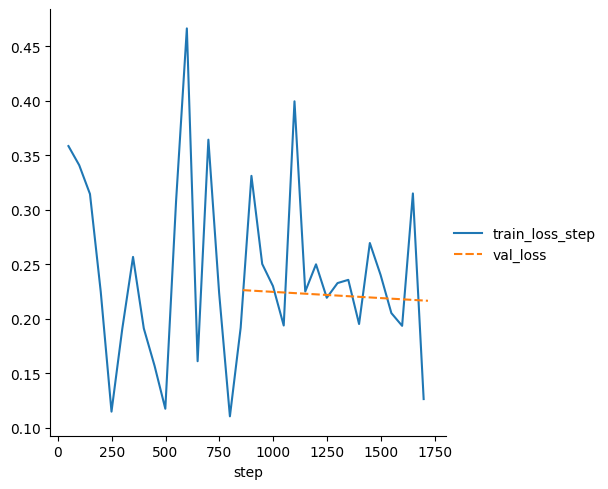

In [14]:
# ## ---- Display Log ---- ##
import pandas as pd
import seaborn as sn

df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
df.head()
v_df = df[['step', 'train_loss_step', 'val_loss'] ]
v_df.set_index("step", inplace=True)
sn.relplot(data=v_df, kind="line")

In [15]:
lora_p = print_trainable_parameters( lora_model )

trainable params: 16,000 || all params: 664,010 || trainable : 2.409602265026129%


In [16]:
print(f"\n# Trainable Parameter \nBefore: {ori_p:>14,d} \nAfter:  {lora_p:>14,d} \nPercentage: {round(lora_p / ori_p * 100, 2)}%")


# Trainable Parameter 
Before:        648,010 
After:          16,000 
Percentage: 2.47%


Orignal Model 의 훈련파라미터 수와 LoRA Model 의 훈련파라미터 수를 비교해보시기 바랍니다.

## Analysis Model Structure

In [17]:
model

LitMNIST(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=500, out_features=10, bias=True)
  )
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [18]:
lora_model

LoRALitMNIST(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=500, out_features=500, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=500, out_features=10, bias=True)
  )
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

훈련의 대상이 되는 파라미터만 따로 출력해봅니다.

In [19]:
def show_trainable_structure(model):
    for _, param in model.named_parameters():
        if param.requires_grad:
            print( f"{_} \t {param.shape} \t\t {param.numel():,}" )


In [20]:
show_trainable_structure(model)

model.1.weight 	 torch.Size([500, 784]) 		 392,000
model.1.bias 	 torch.Size([500]) 		 500
model.4.weight 	 torch.Size([500, 500]) 		 250,000
model.4.bias 	 torch.Size([500]) 		 500
model.7.weight 	 torch.Size([10, 500]) 		 5,000
model.7.bias 	 torch.Size([10]) 		 10


In [21]:
show_trainable_structure(lora_model)

W_A 	 torch.Size([500, 16]) 		 8,000
W_B 	 torch.Size([16, 500]) 		 8,000


## Parameter Efficiency Analysis:

The original `LitMNIST` model contains three linear layers with the following number of trainable parameters:

- **First Linear Layer:** Maps the 784 input features to 500 hidden units. Parameters: $784 \times 500 + 500$ (weights + biases) = $392,500$
- **Second Linear Layer:** Maps 500 hidden units to another 500. Parameters: $500 \times 500 + 500$ (weights + biases) = $250,500$
- **Third Linear Layer:** Maps 500 hidden units to 10 output classes. Parameters: $500 \times 10 + 10$ (weights + biases) = $5,010$

**Total Trainable Parameters in Original Model:** $392,500 + 250,500 + 5,010 = 648,010$

When LoRA is applied in `LoRALitMNIST`, targeting specifically the second linear layer:

- LoRA introduces two matrices $W_A$ and $W_B$ of dimensions $500 \times r$ and $r \times 500$, with $r$ being the rank, set to 16 in this case.
- Instead of training all $500 \times 500$ parameters of the original second layer, only $500 \times 16 + 16 \times 500 = 16,000$ parameters need to be learned for adaptation.


- For the entire model, the reduction is from 648,010 to 16,000, which is about $$\frac{16,000}{648,010} \times 100 \approx 2.469\%$$ of the original total trainable parameters.




In [23]:
!pip freeze > requirements.txt

In [24]:
!python --version

Python 3.11.13


In [25]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [26]:
torch.__version__

'2.6.0+cu124'